# Gather Data using APIs

In [1]:
# data 
# we will try to pull data for AMZN share price
# then we will try to predict the stock prices using vanilla RNN 

In [2]:
!pip install yfinance # uncomment it to download

In [3]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [6]:
# ticker of choice
tick = ['AAPL'] # you can add more or add ticker of choice such as IBM, AAPL, GOOG, GM etc.

# let us start with 2015
begin_period = '2020-06-01'
end_period = '2021-01-01'

In [7]:
import yfinance as yf
# documentation: https://github.com/ranaroussi/yfinance

In [8]:
data = yf.download(tick, start=begin_period, end=end_period)
data.head(4)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-01,79.437500,80.587502,79.302498,80.462502,79.688095,80791200
2020-06-02,80.187500,80.860001,79.732498,80.834999,80.057014,87642800
2020-06-03,81.165001,81.550003,80.574997,81.279999,80.497734,104491200
2020-06-04,81.097504,81.404999,80.195000,80.580002,79.804466,87560400


In [9]:
data.tail(4)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.852524,124486200
2020-12-29,138.050003,138.789993,134.339996,134.869995,134.043640,121047300
2020-12-30,135.580002,135.990005,133.399994,133.720001,132.900711,96452100
2020-12-31,134.080002,134.740005,131.720001,132.690002,131.877014,99116600


## including all weekdays in the data

In [10]:
# quantitative trading strategies often require all weekdays
# df = data.Close
# # let us get all the weekdays in the desired date range
# weekdays = pd.date_range(start= begin_period, end = end_period, freq='B')

# df = df.reindex(weekdays)
# df.head()

In [11]:
# df = pd.DataFrame(df.fillna(method='bfill'))
# df = df.fillna(0)
# df.head()

In [12]:
df = pd.DataFrame(data.Close)
# get rownames as columns
df.index.name = 'Date'
df.reset_index(inplace=True)

In [13]:
df.head(4)

,Date,Close
0,2020-06-01,80.462502
1,2020-06-02,80.834999
2,2020-06-03,81.279999
3,2020-06-04,80.580002


In [14]:
print(df.columns)
print(df.dtypes)
print(df.describe)

Index(['Date', 'Close'], dtype='object')
Date     datetime64[ns]
Close           float64
dtype: object
<bound method NDFrame.describe of           Date       Close
0   2020-06-01   80.462502
1   2020-06-02   80.834999
2   2020-06-03   81.279999
3   2020-06-04   80.580002
4   2020-06-05   82.875000
..         ...         ...
145 2020-12-24  131.970001
146 2020-12-28  136.690002
147 2020-12-29  134.869995
148 2020-12-30  133.720001
149 2020-12-31  132.690002

[150 rows x 2 columns]>


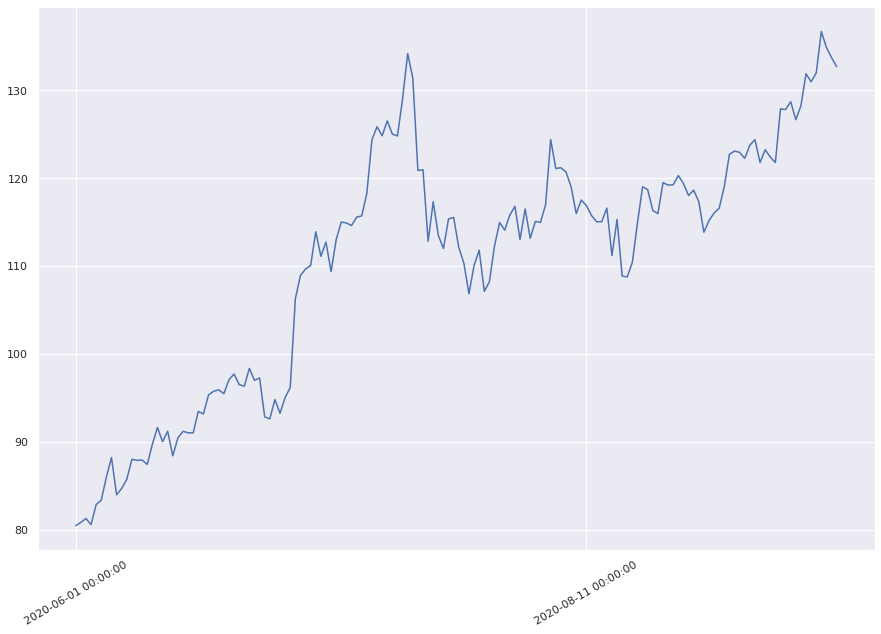

In [15]:
# let us plot this data
# to do:pls complete the figure with adding lables to axes
sns.set_theme()
plt.figure(figsize= (15, 10))
plt.plot(df.Close)
plt.xticks(range(0, df.shape[0], 100), df.Date.loc[::50], rotation=30)
# plt.plot(roll_mean, color='red')

plt.show()

# Data Prep

In [16]:
# min max standardization
scale = MinMaxScaler(feature_range=(-1, 1))
# scale.fit_transform(df.Close.values) # gives error that 2D expected and got 1D
df['Close_norm'] = scale.fit_transform(df.Close.values.reshape(-1, 1))

In [17]:
def train_test_prep(series, window_size, test_prop=0.3): 
  # series should be a numpy series
  series = series.to_numpy()
  data = []
  for i in range(len(series) - window_size):
    data.append(series[i: i+window_size])
  data = np.array(data)

  test_size = int(np.round(test_prop* data.shape[0]))
  train_size = data.shape[0] - test_size

  train_x = data[:train_size, :-1]
  train_y = data[:train_size, -1]

  test_x = data[train_size:, :-1]
  test_y = data[train_size:, -1]

  return [train_x, train_y, test_x, test_y]

In [18]:
ws = 12

x_train, y_train, x_test, y_test = train_test_prep(df[['Close_norm']], ws)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

train_x (97, 11, 1)
train_y (97, 1)
test_x (41, 11, 1)
test_y (41, 1)


In [19]:
# data.Close[:25]

In [20]:
y_train[:5]

array([[-0.73118154],
       [-0.73553875],
       [-0.73429368],
       [-0.75216758],
       [-0.67080176]])

In [21]:
print(x_train[:3])

[[[-1.        ]
  [-0.98675034]
  [-0.9709218 ]
  [-0.99582054]
  [-0.91418795]
  [-0.89675884]
  [-0.80312139]
  [-0.72442319]
  [-0.87506125]
  [-0.84927321]
  [-0.81201384]]

 [[-0.98675034]
  [-0.9709218 ]
  [-0.99582054]
  [-0.91418795]
  [-0.89675884]
  [-0.80312139]
  [-0.72442319]
  [-0.87506125]
  [-0.84927321]
  [-0.81201384]
  [-0.73118154]]

 [[-0.9709218 ]
  [-0.99582054]
  [-0.91418795]
  [-0.89675884]
  [-0.80312139]
  [-0.72442319]
  [-0.87506125]
  [-0.84927321]
  [-0.81201384]
  [-0.73118154]
  [-0.73553875]]]


In [22]:
#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)


In [23]:
print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)

train_x torch.Size([97, 11, 1])
train_y torch.Size([97, 1])
test_x torch.Size([41, 11, 1])
test_y torch.Size([41, 1])


## LSTM

In [24]:
seed = 1234
torch.manual_seed(seed)

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_dim = 1, hidden_dim = 50):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)# outputing 1 value at the end

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).requires_grad_()
        # print(h0.requires_grad)
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))# note: h0, C0 are in a tuple (a, b)
        out = self.fc(out[:, -1, :]) 
        return out

In [26]:
# input_dim = 1
# hidden_dim = 50
# num_layers = 1
# output_dim = 1
num_epochs = 400

In [27]:
model = LSTM()

cr = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
  y_train_pred = model(x_train)
  loss = cr(y_train_pred, y_train)
  print("Epoch ", t, "MSE: ", loss.item())
  hist[t] = loss.item()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.19242754578590393
Epoch  1 MSE:  0.16727231442928314
Epoch  2 MSE:  0.14113867282867432
Epoch  3 MSE:  0.11007761210203171
Epoch  4 MSE:  0.06621286273002625
Epoch  5 MSE:  0.02905738726258278
Epoch  6 MSE:  0.0958605706691742
Epoch  7 MSE:  0.055968012660741806
Epoch  8 MSE:  0.025708695873618126
Epoch  9 MSE:  0.034684713929891586
Epoch  10 MSE:  0.04212744161486626
Epoch  11 MSE:  0.046900779008865356
Epoch  12 MSE:  0.04884715750813484
Epoch  13 MSE:  0.0456993468105793
Epoch  14 MSE:  0.03844697028398514
Epoch  15 MSE:  0.03147512301802635
Epoch  16 MSE:  0.02664908766746521
Epoch  17 MSE:  0.02366989105939865
Epoch  18 MSE:  0.02407660149037838
Epoch  19 MSE:  0.026437291875481606
Epoch  20 MSE:  0.027977826073765755
Epoch  21 MSE:  0.029545927420258522
Epoch  22 MSE:  0.028397176414728165
Epoch  23 MSE:  0.026251856237649918
Epoch  24 MSE:  0.02389807254076004
Epoch  25 MSE:  0.021404845640063286
Epoch  26 MSE:  0.020210782065987587
Epoch  27 MSE:  0.01989774405

In [29]:
predict = pd.DataFrame(scale.inverse_transform(y_train_pred.cpu().detach().numpy()))
original = pd.DataFrame(scale.inverse_transform(y_train.cpu().detach().numpy()))

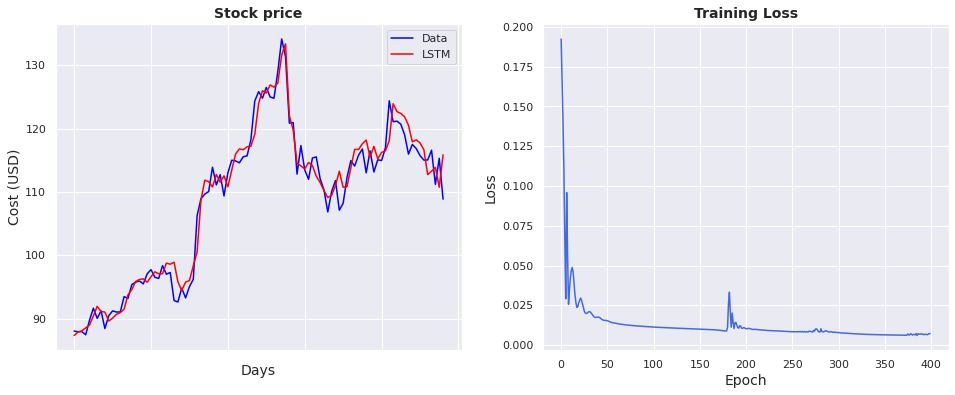

In [30]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="LSTM", color='red')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [31]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
model.eval()
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scale.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scale.inverse_transform(y_train.cpu().detach().numpy())
y_test_pred = scale.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scale.inverse_transform(y_test.cpu().detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 2.39 RMSE
Test Score: 6.77 RMSE


In [32]:
# Train Score: 2.26 RMSE
# Test Score: 4.64 RMSE

In [33]:
# future prediction
x_train, y_train, x_test, y_test = train_test_prep(df[['Close_norm']], ws, test_prop=0.0)

print('train_x', x_train.shape)#train_x (2106, 11, 1)
print('train_y', y_train.shape)#train_y (2106, 1)

print('test_x', x_test.shape)#test_x (902, 11, 1)
print('test_y', y_test.shape)#test_y (902, 1, 1)
#  put all arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

train_x (138, 11, 1)
train_y (138, 1)
test_x (0, 11, 1)
test_y (0, 1)


In [34]:
# re-train the whole model
# set model to back to training mode
model.train()
import time

losses = np.zeros(num_epochs)
start = time.time()
rnn = []

for epoch in range(num_epochs):
  optimizer.zero_grad()
  # model.hidden = torch.zeros(1,1,model.hidden_size).cuda()
  y_train_pred = model(x_train)

  loss = cr(y_train_pred, y_train)
  print('Epoch number: ', epoch, 'Error: ', loss.item())
  losses[epoch] = loss.item()
  loss.backward()
  optimizer.step()

print('training took: ', time.time() - start)

Epoch number:  0 Error:  0.0220967885106802
Epoch number:  1 Error:  0.016038861125707626
Epoch number:  2 Error:  0.020437655970454216
Epoch number:  3 Error:  0.014002377167344093
Epoch number:  4 Error:  0.011912796646356583
Epoch number:  5 Error:  0.014117391780018806
Epoch number:  6 Error:  0.011543248780071735
Epoch number:  7 Error:  0.008922507055103779
Epoch number:  8 Error:  0.00991260539740324
Epoch number:  9 Error:  0.010786912404000759
Epoch number:  10 Error:  0.009756668470799923
Epoch number:  11 Error:  0.008809139020740986
Epoch number:  12 Error:  0.008280306123197079
Epoch number:  13 Error:  0.00896987970918417
Epoch number:  14 Error:  0.00933086033910513
Epoch number:  15 Error:  0.008858050219714642
Epoch number:  16 Error:  0.008415939286351204
Epoch number:  17 Error:  0.008282750844955444
Epoch number:  18 Error:  0.00834579300135374
Epoch number:  19 Error:  0.008708115667104721
Epoch number:  20 Error:  0.00856349803507328
Epoch number:  21 Error:  0.00

In [35]:
model

LSTM(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [36]:
# feed = y_train[-11:].view(1,11,1)# reshape it to suit the input shape of 1,11,1
feed = torch.from_numpy(df['Close_norm'].iloc[-ws:].values).type(torch.Tensor).view(-1,ws, 1)

last = feed.cpu().numpy()
new_predictions = []
model.eval()
# make predictions
for i in range(ws):
  print('before', last)
  last_tensor = torch.from_numpy(last).type(torch.Tensor).view(-1,ws, 1)
  pred = model(last_tensor)
  new_predictions.append(pred.item())
  newpred = pred.cpu().detach().numpy()
  last = np.append(last, newpred)[-ws:]
  # print('after', last)

before [[[0.68663   ]
  [0.68414015]
  [0.71579725]
  [0.64323515]
  [0.6990794 ]
  [0.82890946]
  [0.7961853 ]
  [0.8321106 ]
  [1.        ]
  [0.93526274]
  [0.8943577 ]
  [0.85772085]]]
before [0.68414015 0.71579725 0.64323515 0.6990794  0.82890946 0.7961853
 0.8321106  1.         0.93526274 0.8943577  0.85772085 0.83320606]
before [0.71579725 0.64323515 0.6990794  0.82890946 0.7961853  0.8321106
 1.         0.93526274 0.8943577  0.85772085 0.83320606 0.80881536]
before [0.64323515 0.6990794  0.82890946 0.7961853  0.8321106  1.
 0.93526274 0.8943577  0.85772085 0.83320606 0.80881536 0.7846668 ]
before [0.6990794  0.82890946 0.7961853  0.8321106  1.         0.93526274
 0.8943577  0.85772085 0.83320606 0.80881536 0.7846668  0.7607657 ]
before [0.82890946 0.7961853  0.8321106  1.         0.93526274 0.8943577
 0.85772085 0.83320606 0.80881536 0.7846668  0.7607657  0.73792183]
before [0.7961853  0.8321106  1.         0.93526274 0.8943577  0.85772085
 0.83320606 0.80881536 0.7846668  0.76

In [37]:
df['Close'].iloc[-11:]

139    127.809998
140    128.699997
141    126.660004
142    128.229996
143    131.880005
144    130.960007
145    131.970001
146    136.690002
147    134.869995
148    133.720001
149    132.690002
Name: Close, dtype: float64

In [38]:
unscale_new_predictions_lstm = scale.inverse_transform(np.array(new_predictions).reshape(-1, 1))
unscale_new_predictions_lstm

array([[132.00079917],
       [131.31508518],
       [130.63617794],
       [129.96422824],
       [129.32200228],
       [128.71312631],
       [128.14124332],
       [127.60644379],
       [127.11092123],
       [126.65247208],
       [126.22854758],
       [125.83716538]])

In [39]:
wht = yf.download(tick, start="2021-01-01", end="2021-01-21")['Close']

[*********************100%***********************]  1 of 1 completed


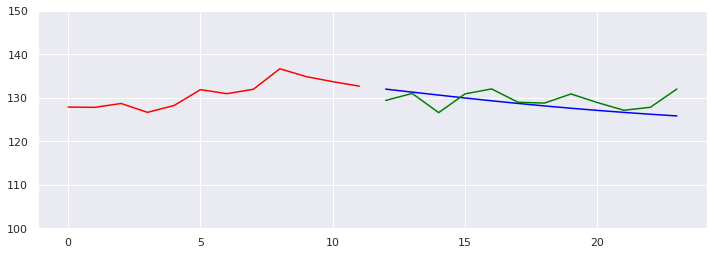

In [40]:
# [x for x in range(12,24)]
fig = plt.figure(figsize=(12,4))
plt.ylim([100, 150])
plt.plot([x for x in range(12)], df.Close[-12:], color = 'red')
plt.plot([x for x in range(12,24)], unscale_new_predictions_lstm, color = 'blue')
plt.plot([x for x in range(12,24)], wht, color='green')
plt.show()

In [41]:
fut_pred = 12

test_inputs = df['Close_norm'][-11:].tolist()
print(test_inputs)

[0.6841401542582068, 0.7157972393200356, 0.6432351210356901, 0.6990793979416954, 0.8289094311404672, 0.7961852960120903, 0.8321105813401117, 1.0000000000000004, 0.9352627346197369, 0.8943577013972193, 0.8577208684408952]


In [42]:
model.eval()
feed = torch.from_numpy(df['Close_norm'].iloc[-11:].values).type(torch.Tensor).view(-1,11, 1)
for i in range(fut_pred):
    seq = feed
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_dim),
                        torch.zeros(1, 1, model.hidden_dim))
        test_inputs.append(model(seq).item())

In [43]:
test_inputs[fut_pred:]

[0.833838939666748,
 0.833838939666748,
 0.833838939666748,
 0.833838939666748,
 0.833838939666748,
 0.833838939666748,
 0.833838939666748,
 0.833838939666748,
 0.833838939666748,
 0.833838939666748,
 0.833838939666748]